In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
from helpers import getStats, plotDict, genome2tabInt,plot_confusion_matrix, kmer_count, build_pipeline, plot_confusion_matrix 
from sklearn.preprocessing import normalize
from scipy.spatial import distance
import json 
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random


## Load training data 

For this example thge file ```train1.p``` contains the training data for the Hapatitis B virus subtyping task

-----------some stats: ------------
total num of classes:  13
total num of samples:  5460
max genome length:  3257
occurences: 
D        =>      736
RF-CB    =>      256
RF-DE    =>      161
B        =>     1338
RF-DC    =>      109
F        =>      188
E        =>      215
G        =>       31
RF-BC    =>       21
H        =>       18
A        =>      639
RF-GC    =>       11
C        =>     1737
-----------------------------------


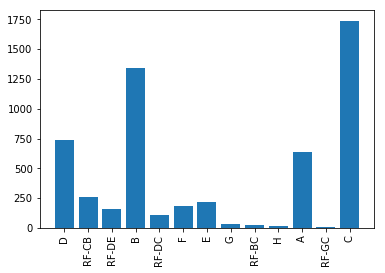

{'D': 1, 'RF-CB': 2, 'RF-DE': 3, 'B': 4, 'RF-DC': 5, 'F': 6, 'E': 7, 'G': 8, 'RF-BC': 9, 'H': 10, 'A': 11, 'RF-GC': 12, 'C': 13}


In [2]:
TrainDataFile = 'train1.p'

train = pickle.load(open(TrainDataFile, "rb"))
max_ = len(train[0][1])

#get some stats about training and testing dataset
diTrain = getStats(train)
plotDict(diTrain, 'train.png')

# Create Labels for Classes
diLabels = {}
classId = 0;
numClasses = len(diTrain)

for item in diTrain:
    classId += 1
    diLabels[item] = classId;
    
print(diLabels)


In [3]:
n_train = len(train)
k = 5
train_features = []
train_labels = []

for i in range(len(train)):
    train_features.append(kmer_count(train[i][1].upper(),k))
    train_labels.append(train[i][0])

x = np.asarray(train_features).astype('float32')
x = normalize(x,norm='l2',axis=1) 
y = np.asarray(train_labels)

features = normalize(x,norm='l2',axis=1) 
subtypes = np.asarray(train_labels)



We buld the similarity Matrix at this step so that we can use it later. This is done to increase efficiency.

In [4]:
m = features.shape[0] #Dimension of the similarity matrix
print(m)

Similarity=np.zeros((m,m))

for i in range(m):
    for j in range(i+1,m):
        d = distance.cityblock(features[i,:],features[j,:])
        Similarity[i][j] = d
        Similarity[j][i] = d


5460


In [5]:
with open('New_Similarity_Manhattan.json', 'w') as json_file:
    json.dump(Similarity.tolist(),json_file)

## Plotting the data to see it's structure

[0.15870455 0.14475128]
0.30345583


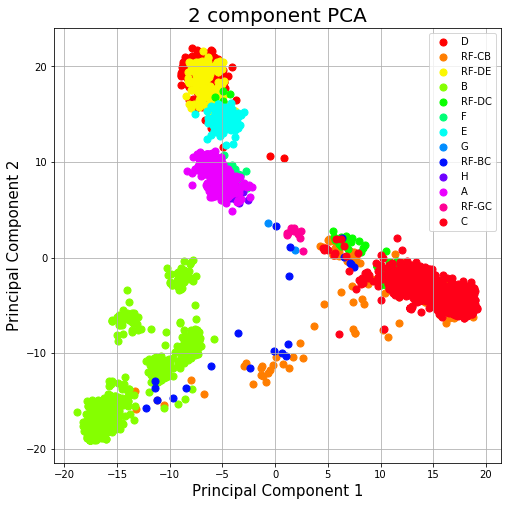

In [5]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)


#standarize the data
x = StandardScaler().fit_transform(features)


# Define and calculate the PCA analysis.
pca = PCA(n_components=2)
principal = pca.fit_transform(x)



# Visualization
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title("2 component PCA", fontsize = 20)

cmap = get_cmap(len(diLabels.keys()))

for i, target in enumerate(diLabels.keys()):
    indicesToKeep = subtypes == target
    ax.scatter(principal[indicesToKeep,0]
               , principal[indicesToKeep,1]
               , c = np.array(cmap(i)).reshape((1,-1))
               , s = 50)
ax.legend(diLabels.keys())
ax.grid()

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
plt.show()


[0.15870456 0.14475118 0.09327235]
0.3967281


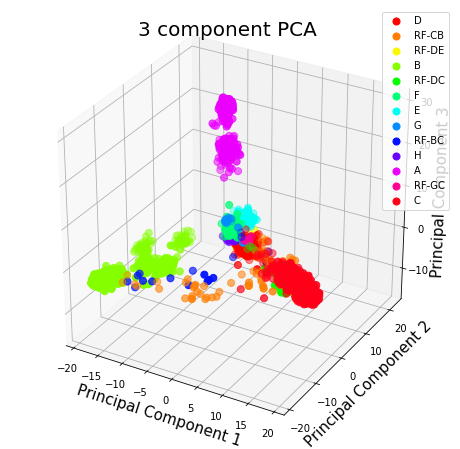

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Define and calculate the PCA analysis.
pca = PCA(n_components=3)
principal = pca.fit_transform(x)

# Visualization
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title("3 component PCA ", fontsize = 20)

cmap = get_cmap(len(diLabels.keys()))

for i, target in enumerate(diLabels.keys()):
    indicesToKeep = subtypes == target
    ax.scatter(principal[indicesToKeep,0]
               , principal[indicesToKeep,1]
               , principal[indicesToKeep,2]
               , c = np.array(cmap(i)).reshape((1,-1))
               , s = 50)
ax.legend(diLabels.keys())
ax.grid()

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
plt.show()


## Cross Validation for Hyperparameter Tunning

We are using 10% of labeled data. The hyperparameter that we are tunning is the radio of the neighborhood in the Kernel. This radio is the Manhattan distance, that is shown to be the best one.

In [7]:
import random 

train_idx = list(range(m))
validation_indices = np.array_split(np.random.permutation(train_idx),10)

#print("Loading similarity matrix ...")
#with open('Distance Matrix/Similarity_Manhattan.json', 'r') as json_file:
#  Similarity=np.array(json.load(json_file))
#print("Matrix Loaded")

# For finding the Neighborhood we will optimize the "thr" hyperparameter  via
# Cross validation.

training_scores=np.zeros_like(np.arange(0.10,0.20,0.01))
j=0

for thr in np.arange(0.10,0.20,0.01):

    for test_indices in validation_indices:

            train_indices = list(set(range(m)).difference(test_indices))

            num_train_points = len(train_indices)
  
            # split training and testing feature vectors
            train_features = features[train_indices,:]
            test_features = features[test_indices,:]

            train_classes = subtypes[train_indices]
            test_realclasses = subtypes[test_indices]


            # We will consider just half of the sequences as labeled ones and
            # we wil take just the indices
            labeled_index=random.sample(train_indices,int(num_train_points/10))

            #New Mapping just for the labeled data.

            new_X_train=np.zeros((int(num_train_points/10),1024))
            new_y_train=[]

            k=0

            for i in labeled_index:
                d=Similarity[i,train_indices]<thr
                neig=train_features[d,:]
                new_X_train[k,:]=np.mean(neig,axis=0)
                new_y_train.append(subtypes[i])
                k+=1

            # Run the classification Pipeline for this subset.
            
            pipeline = build_pipeline(1024)
            pipeline.fit(new_X_train, new_y_train)
            y_pred=pipeline.predict(test_features)
            training_scores[j] += accuracy_score(np.array(test_realclasses),y_pred)


    # Now compute the average accuracy for each value of thr and save the value in an array.
    training_scores[j] /= 10
    print(training_scores[j])
    j+=1


0.934981684981685
0.9338827838827839
0.924908424908425
0.9333333333333333
0.9291208791208792
0.9285714285714286
0.9280219780219781
0.9294871794871795
0.9282051282051282
0.928937728937729


## Loading Testing Data 

For this example thge file ```test1.p```contains the training data for the Hapatitis B virus subtyping task


-----------some stats: ------------
total num of classes:  13
total num of samples:  1364
max genome length:  3257
occurences: 
D        =>      208
RF-CB    =>       55
RF-DE    =>       48
B        =>      345
RF-DC    =>       19
F        =>       58
E        =>       40
G        =>        8
H        =>        8
RF-BC    =>        2
A        =>      176
RF-GC    =>        4
C        =>      393
-----------------------------------


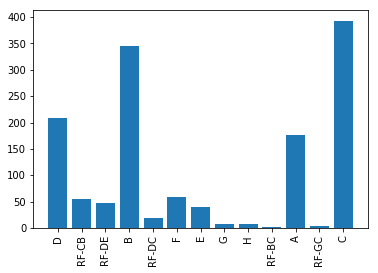

In [8]:
TestDataFile = 'test1.p'
test = pickle.load(open(TestDataFile, "rb"))
n_test = len(test)

k = 5
test_features = []
test_labels = []

for i in range(len(test)):
    test_features.append(kmer_count(test[i][1].upper(),k))
    test_labels.append(test[i][0])
    
x = np.asarray(test_features).astype('float32')
y = np.asarray(test_labels)

test_features = normalize(x,norm='l2',axis=1) 

#get some stats about training and testing dataset
diTest = getStats(test)
plotDict(diTest, 'train.png')


## Evaluating the model 


In [14]:
train_idx = list(range(m))

thr=0.1

#print("Loading similarity matrix ...")
#with open('New_Similarity_Manhattan.json', 'r') as json_file:
#    Similarity=np.array(json.load(json_file))
#print("Matrix Loaded")

labeled_index=random.sample(train_idx,int(m/10))

#New Mapping just for the labeled data.

new_X_train=np.zeros((int(m/10),1024))
new_y_train=[]

k=0

for i in labeled_index:
    d=Similarity[i,train_idx]<=thr
    neig=features[d,:]
    new_X_train[k,:]=np.mean(neig,axis=0)
    new_y_train.append(subtypes[i])
    k+=1

# Run the classification Pipeline for this subset.

pipeline = build_pipeline(1024)
pipeline.fit(new_X_train, np.array(new_y_train))
y_pred=pipeline.predict(test_features)

print(y)
print(y_pred)
print(accuracy_score(y,y_pred))

['F' 'D' 'G' ... 'A' 'B' 'C']
['F' 'D' 'G' ... 'A' 'B' 'C']
0.9252199413489736


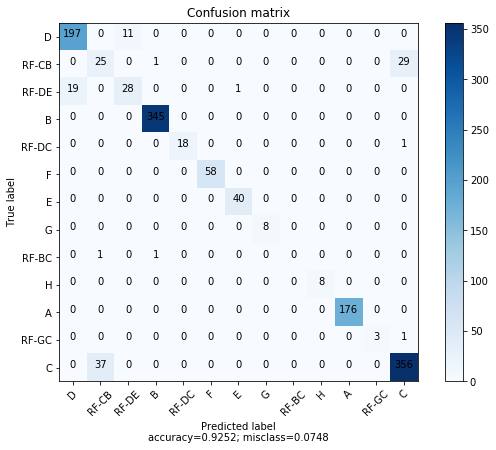

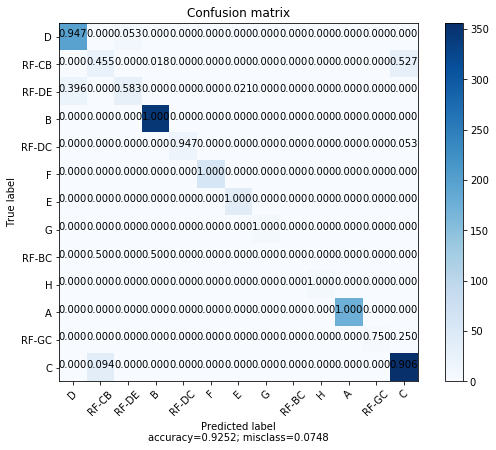

In [15]:
#evaluation by class

classes = p = list(diLabels.keys())


confusionMatrix = np.zeros((len(p),len(p)), dtype = 'int')

for y1,y2 in zip(y,y_pred):
    i=p.index(y1)
    j=p.index(y2)
    confusionMatrix[i,j] += 1


#sorted_by_labels = sorted(diClasses.items(), key=operator.itemgetter(1))
#p, q = zip(*sorted_by_labels)

plot_confusion_matrix(cm=confusionMatrix, target_names = p, normalize=False)
plot_confusion_matrix(cm=confusionMatrix, target_names = p, normalize=True)
